In [27]:
import pandas as pd
import cobra
from copy import deepcopy
from cobra import Model, Reaction, Metabolite
from optlang.symbolics import add
from optlang.interface import OPTIMAL
import joblib
from joblib import Parallel, delayed
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Bigg metabolite metadata

In [2]:
df_bigg_mets = pd.read_csv("Bigg/bigg_models_metabolites.txt", sep="\t")
df_bigg_mets.head()

bigg_id universal_bigg_id  \
0  12dgr120_c          12dgr120   
1  12dgr140_c          12dgr140   
2  12dgr180_c          12dgr180   
3  14glucan_c          14glucan   
4     15dap_c             15dap   

                                                name  \
0     1,2-Diacyl-sn-glycerol (didodecanoyl, n-C12:0)   
1  1,2-Diacyl-sn-glycerol (ditetradecanoyl, n-C14:0)   
2   1,2-Diacyl-sn-glycerol (dioctadecanoyl, n-C18:0)   
3                                 1,4-alpha-D-glucan   
4                                 1,5-Diaminopentane   

                                          model_list  \
0  iEC1364_W; iEC1349_Crooks; iEC1356_Bl21DE3; iM...   
1  iECNA114_1301; iECSE_1348; iECO111_1330; iECOK...   
2  iECB_1328; iECDH10B_1368; iEcE24377_1341; iECD...   
3  iSFxv_1172; iUTI89_1310; iSSON_1240; iSbBS512_...   
4  iECUMN_1333; iLF82_1304; iETEC_1333; iECSF_132...   

                                      database_links  \
0  MetaNetX (MNX) Chemical: http://identifiers.or...   
1  MetaNetX (MNX) Chemical: http://identifiers.or...   
2  MetaNetX (MNX) Chemical: http://identifiers.or...   
3  BioCyc: http://identifiers.org/biocyc/META:1-4...   
4  KEGG Compound: http://identifiers.org/kegg.com...   

                                     old_bigg_ids  
0  12dgr120; 12dgr120[c]; 12dgr120_c; _12dgr120_c  
1  12dgr140; 12dgr140[c]; 12dgr140_c; _12dgr140_c  
2  12dgr180; 12dgr180[c]; 12dgr180_c; _12dgr180_c  
3                            14glucan; 14glucan_c  
4                        15dap; 15dap[c]; 15dap_c

# Bigg reaction pool

In [3]:
bigg = cobra.io.read_sbml_model("Bigg/bigg_universe_compartment_cpe.xml")
bigg.remove_reactions([bigg.reactions.St]) # it seems that this reaction (St) produces error in gapfill

Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-01


No objective coefficients in model. Unclear what should be optimized


# Strain metadata

In [25]:
df_strain_meta = pd.read_csv('Data/han_nature_strain_metadata.csv')
df_strain_meta = df_strain_meta[df_strain_meta.source != "Not found"]
print("found %d strains with genomes."%(len(df_strain_meta)))
df_strain_meta.head()

found 167 strains with genomes.


genome_id                                     taxonomy NCBI organism name  \
0       G82   Clostridium aldenense WAL-18727 BEI HM-307                NaN   
1      G150      Muribaculum intestinale DSMZ 28989 YL27                NaN   
2       G89      Clostridium cadaveris CC88A BEI HM-1041                NaN   
3       G10         Atopobium parvulum CC14Z BEI HM-1035                NaN   
4       G88  Clostridium cadaveris CC44_001G BEI HM-1040                NaN   

  NCBI strain name NCBI assembly ID  \
0        WAL-18727              NaN   
1        DSM 28989              NaN   
2            CC88A              NaN   
3            CC14Z              NaN   
4        CC44_001G              NaN   

                                        source  cstr_num_total  cstr_num_used  
0   De novo assembly of SRR058688 using SPAdes            29.0           21.0  
1  De novo assembly of SRR2124911 using SPAdes             NaN            NaN  
2   De novo assembly of SRR770200 using SPAdes            39.0           32.0  
3   De novo assembly of SRR770242 using SPAdes            25.0           25.0  
4   De novo assembly of SRR770461 using SPAdes            50.0            5.0

# Metabolomics metadata

In [5]:
df_exp = pd.read_excel('Data/han_nature_metabolomics_peak_fc.xlsx', sheet_name='aggregated_md', engine='openpyxl', index_col=0)
df_exp = df_exp[df_exp.media=='mm']
df_exp.experiment = df_exp.experiment.astype(int)
df_exp.head()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


experiment  sample_type media  subculture_time  preculture_time  \
4     20190228  media_blank    mm            17.25              NaN   
5     20190228  media_blank    mm            17.25              NaN   
6     20190228  media_blank    mm            17.25              NaN   
13    20181030  supernatant    mm            12.00             30.0   
14    20180512  supernatant    mm            12.00             24.0   

   c18positive c18negative hilicpositive culture_source  \
4       s03818      s03658        s03513            NaN   
5       s03819      s03659        s03514            NaN   
6       s03820      s03660        s03515            NaN   
13      s03029      s03130        s02928          c0206   
14      s00010      s00131        s00218          c0009   

                                      taxonomy              grouped_taxonomy  \
4                                          NaN                           NaN   
5                                          NaN                           NaN   
6                                          NaN                           NaN   
13       Bacteroides thetaiotaomicron VPI 5482  Bacteroides thetaiotaomicron   
14  Anaerostipes sp. 3_2_56FAA BEI HM-220 904a                  Anaerostipes   

     kingdom         phylum        class          order           family  \
4        NaN            NaN          NaN            NaN              NaN   
5        NaN            NaN          NaN            NaN              NaN   
6        NaN            NaN          NaN            NaN              NaN   
13  Bacteria  Bacteroidetes  Bacteroidia  Bacteroidales   Bacteroidaceae   
14  Bacteria     Firmicutes   Clostridia  Clostridiales  Lachnospiraceae   

           genus           species     strain morphology  
4            NaN               NaN        NaN        NaN  
5            NaN               NaN        NaN        NaN  
6            NaN               NaN        NaN        NaN  
13   Bacteroides  thetaiotaomicron        NaN        NaN  
14  Anaerostipes               NaN  3_2_56FAA       904a

# Metabolomics fold change

In [6]:
df_fc = pd.read_csv('Data/han_nature_log2fc_metabolites_w_biggid_stats.csv')
df_fc.head()

genome_id universal_bigg_id media  n_reps  log2fc_mean  log2fc_var  \
0      G124            hom__L    mm       3     0.001837    0.000852   
1      G124               gly    mm       3    -0.390934    0.003383   
2      G124               ins    mm       3     0.258325    0.000304   
3      G124              pala    mm       3    -0.248922    0.001139   
4      G124            pro__L    mm       3    -0.054691    0.001453   

   log2fc_P  log2fc_Padj  
0  0.937202     0.947879  
1  0.010889     0.026179  
2  0.002269     0.008534  
3  0.009067     0.022890  
4  0.179617     0.237555

# Growth rate

In [7]:
df_growth = pd.read_csv("Data/han_nature_computed_max_growth_rate.csv")
df_growth.head()

sample_id                                    taxonomy  experiment  \
0   od00001          Bacteroides coprophilus DSMZ 18228  20180512.0   
1   od00002            Bacteroides eggerthii DSMZ 20697  20180512.0   
2   od00003  Bacteroides xylanoisolvens XB1A DSMZ 18836  20180512.0   
3   od00004              Prevotella buccalis ATCC 35310  20180512.0   
4   od00005     Bacteroides cellulosilyticus DSMZ 14838  20180512.0   

  od_loc_well  preculture_date  preculture_time  subculture_time media  \
0         A01         20180512             24.0              NaN    mm   
1         A02         20180512             24.0              NaN    mm   
2         A03         20180512             24.0              NaN    mm   
3         A04         20180512             24.0              NaN    mm   
4         A05         20180512             24.0              NaN    mm   

   max_growth        r2  
0    0.000000       NaN  
1    0.045154  0.984185  
2    0.088190  0.998253  
3    0.084855  0.998140  
4    0.045433  0.998794

# Self-defined functions for gapfilling and flux optimization

In [8]:
def gapfilling_by_metabolomics(genome_id, medium='mm', max_flux=1000.0, min_flux=0.01):
    
    # the gapfilled model exists
    if os.path.exists("GSM_gapfilled_models/%s_gf.pickle"%(genome_id)):
        return 0
    
    # load culture medium
    df_mm = pd.read_csv('Medium/%s.tsv'%(medium), sep='\t')
    
    # load model
    model = cobra.io.read_sbml_model("GSM_carveme_draft/%s_carveme.xml"%(genome_id))
    model.solver = 'cplex'
    
    # make all internal exchange reactions open
    for ex in model.exchanges:
        ex.bounds = (-max_flux, max_flux)
    
    # get consumed and produced metabolites
    df2_fc = df_fc[(df_fc.log2fc_Padj<0.05) & (df_fc.genome_id==genome_id) & (df_fc.media==medium)]
    
    # add exchange reactions for all metabolites in culture medium
    # note that some compounds are not present in the culture medium but can be produced such as dad_5 (not sure how they calculate the fold change in this case)
    rxns2add = []
    for cpd in set(list(df_mm.compound)+list(df2_fc.universal_bigg_id)):
        if 'EX_%s_e'%(cpd) not in model.reactions:
            name = df_bigg_mets.loc[df_bigg_mets.universal_bigg_id==cpd, 'name']

            # create met_e and met_p if they do not exist
            met_e = Metabolite(
                    '%s_e'%(cpd),
                    name=name,
                    compartment='C_e')

            # add exchange reaction between environment and extracellular space
            reaction_ee = Reaction('EX_%s_e'%(cpd))
            reaction_ee.name = 'R_EX_%s_e'%(cpd)
            reaction_ee.subsystem = ''
            reaction_ee.gene_reaction_rule = ''
            reaction_ee.lower_bound = -1000.0
            reaction_ee.upper_bound =  1000.0
            reaction_ee.add_metabolites({met_e: -1.0})
            rxns2add.extend([reaction_ee])
    if len(rxns2add)>0:
        print('%d exchange reactions are added.'%(len(rxns2add)))
        model.add_reactions(set(rxns2add))
    assert model.slim_optimize()>0.0

    # gapfilling for metabolites consumed and produced
    gapfilling_results = {}
    for bigg_id, log2fc_mean in zip(df2_fc.universal_bigg_id, df2_fc.log2fc_mean):
        model2 = deepcopy(model)
        if log2fc_mean < 0:
            # consumed
            model2.objective = -model2.reactions.get_by_id("EX_%s_e"%(bigg_id)).flux_expression
        else:
            # produced
            model2.objective =  model2.reactions.get_by_id("EX_%s_e"%(bigg_id)).flux_expression
        if model2.slim_optimize() < min_flux:
            print(bigg_id, "needs gapfilling.")
            # run gapfilling (one iteration)
            try:
                result = cobra.flux_analysis.gapfill(model2, universal=bigg, lower_bound=min_flux, demand_reactions=False, iterations=1)
                 # add gapfilled reactions
                model2.add_reactions(result[0])
                assert model2.slim_optimize() >= min_flux
                model = deepcopy(model2)
                print("gapfilling succeeds for %s."%(bigg_id))
                gapfilling_results[bigg_id] = 1
            except:
                print("gapfilling fails for %s."%(bigg_id))
                gapfilling_results[bigg_id] = -1
        else:
            print("gapfilling not needed for %s."%(bigg_id))
            gapfilling_results[bigg_id] = 0
            
    joblib.dump([model, gapfilling_results], "GSM_gapfilled_models/%s_gf.pickle"%(genome_id))
    return 1

In [9]:
def find_solution(model, pFBA=False):
    model.solver.problem.parameters.mip.tolerances.integrality.set(1e-9)
    if pFBA==True:
        solution = cobra.flux_analysis.pfba(model)
    else:
        try:
            solution = model.optimize(raise_error=False)
        except:
            print('first run:')
            print('optlang solver status: %s.' % (str(model.solver.status)))
            print('cplex solver status (%d): %s.'%(model.solver.problem.solution.get_status(), model.solver.problem.solution.get_status_string()))
    if model.solver.status != OPTIMAL: # get cplex return code: model2.solver.problem.solution.get_status()
        for method in ["primal","dual","network","barrier","sifting","concurrent"]:
            model.solver.configuration.lp_method = method
            if method != "sifting" and method != "concurrent":
                model.solver.configuration.qp_method = method
            if pFBA==True:
                solution = cobra.flux_analysis.pfba(model)
            else:
                try:
                    solution = model.optimize(raise_error=False)
                except:
                    print('LP/QP method: %s'%(method))
                    print('optlang solver status: %s.' % (str(model.solver.status)))
                    print('cplex solver status (%d): %s.'%(model.solver.problem.solution.get_status(), model.solver.problem.solution.get_status_string()))
            if model.solver.status == OPTIMAL:
                return model, solution
        if model.solver.status != OPTIMAL:
            return model, None
    else:
        return model, solution

In [10]:
def optimize_flux(model, genome_id, medium='mm', max_flux=1000.0, min_flux=0.01):
    
    # get observed biomass flux
    taxonomy = list(df_strain_meta.loc[df_strain_meta.genome_id==genome_id, "taxonomy"])[0]
    print(taxonomy)
    biomass_flux = list(df_growth.loc[(df_growth.taxonomy==taxonomy) & (df_growth.media==medium), 'max_growth'])
    
    # get biomass reaction id
    biomass_rxn_ids = [rxn.id for rxn in model.reactions if "biom" in rxn.id.lower() or "growth" in rxn.id.lower()]
    assert len(biomass_rxn_ids)==1
    biomass_rxn_id = biomass_rxn_ids[0]
    
    # get consumed and produced metabolites
    df2_fc = df_fc[(df_fc.log2fc_Padj<0.05) & (df_fc.genome_id==genome_id) & (df_fc.media==medium)]
    
    #--------------------------------------------------
    # Constrain reactions with significant fold changes
    #--------------------------------------------------
    model2 = deepcopy(model)
    model2.reactions.get_by_id(biomass_rxn_id).bounds = (np.nanmin(biomass_flux), np.nanmax(biomass_flux)) # constrain biomass flux

    # set indicator variables for import and export reactions
    all_indicator_variables = []
    exchange_reactions_added = []
    for bigg_id, log2fc_mean, log2fc_Padj in zip(df2_fc.universal_bigg_id, df2_fc.log2fc_mean, df2_fc.log2fc_Padj):
        var = model2.problem.Variable('sig_met_fc_' + bigg_id, lb=0, ub=1, type='binary')
        exchange_reactions_added.append('EX_%s_e'%(bigg_id))
        all_indicator_variables.append(-np.log(log2fc_Padj)*var)
        if log2fc_mean < 0:
            # flux <= max_flux * var - min_flux
            # if var = 0, flux <= -min_flux
            con = model2.problem.Constraint((model2.reactions.get_by_id("EX_%s_e"%(bigg_id)).flux_expression - max_flux * var).expand(),
                                           name = 'con_uptake_' + bigg_id,
                                           ub=-min_flux)
        else:
            # flux >= -max_flux * var + min_flux
            # if var = 0, flux >= min_flux
            con = model2.problem.Constraint((model2.reactions.get_by_id("EX_%s_e"%(bigg_id)).flux_expression + max_flux * var).expand(),
                                           name = 'con_secretion_' + bigg_id,
                                           lb=min_flux)
        model2.add_cons_vars([var,con])
        model2.solver.update()
                
    # minimize sum of indicator variables
    model2.objective = add(*all_indicator_variables)
    model2.objective.direction = "min" 
    model2.solver.update()
    model2, solution = find_solution(model2, pFBA=False)
    if solution is None:
        raise RuntimeError("All LP methods fail. Exit.")
            
    # constrain the fluxes based on the solutions
    obj_value = 0
    for ex in model.exchanges: # IMPORTANT: use model, not model2
        if ex.id in exchange_reactions_added:
            bigg_id = ex.id.split('EX_')[1].split('_e')[0]
            log2fc = list(df2_fc.loc[df2_fc.universal_bigg_id==bigg_id, 'log2fc_mean'])[0]
            var_primal = model2.variables['sig_met_fc_' + bigg_id].primal
            obj_value += var_primal
            assert var_primal == 0.0 or var_primal == 1.0
            if var_primal == 0.0:
                if log2fc < 0:
                    ex.bounds = (-max_flux, -min_flux)
                else:
                    ex.bounds = (min_flux, max_flux)
            else:
                # did it wrong
                print(ex.id)
                ex.bounds = (-max_flux, max_flux)
                
    #print('pro__L lower bound', model.reactions.EX_pro__L_e.bounds)
    print("Constrain reactions with significant fold changes finished. Obj = %2.2f."%(obj_value))
                
    #-----------------------------------------------------------
    # Constrain other reactions without significant fold changes
    #-----------------------------------------------------------
    model2 = deepcopy(model)
    model2.reactions.get_by_id(biomass_rxn_id).bounds = (np.nanmin(biomass_flux), np.nanmax(biomass_flux)) # constrain biomass flux

    # set indicator variables for import and export reactions
    all_indicator_variables_2 = []
    exchange_reactions_added_2 = []
    for ex in model2.exchanges:
        if ex.id not in exchange_reactions_added:
            bigg_id = ex.id.split('EX_')[1].split('_e')[0]
            var = model2.problem.Variable('other_ex_var_' + bigg_id, lb=0, ub=1, type='binary')
            all_indicator_variables_2.append(var)
            con_u = model2.problem.Constraint((ex.flux_expression - max_flux * var).expand(),
                                             name = 'con_uptake_' + bigg_id,
                                             ub=0)
            con_s = model2.problem.Constraint((ex.flux_expression + max_flux * var).expand(),
                                             name = 'con_secretion_' + bigg_id,
                                             lb=0)
            model2.add_cons_vars([var,con_u,con_s])
            model2.solver.update()
    
    # minimize sum of indicator variables
    model2.objective = add(*all_indicator_variables_2)
    model2.objective.direction = "min" 
    model2.solver.update()
    model2, solution = find_solution(model2, pFBA=False)
    if solution is None:
        raise RuntimeError("All LP methods fail. Exit.")
            
    # constrain fluxes based on solutions
    for ex in model.exchanges: # IMPORTANT: use model, not model2
        if ex.id in exchange_reactions_added_2:
            bigg_id = ex.id.split('EX_')[1].split('_e')[0]
            var_primal = model2.variables['other_ex_var_' + bigg_id].primal
            assert var_primal == 0.0 or var_primal == 1.0
            if var_value == 0.0:
                ex.bounds = (0.0, 0.0)
               
    #print('pro__L lower bound', model.reactions.EX_pro__L_e.bounds)
    print("Constrain reactions without significant fold changes finished. Obj = %2.2f."%(solution.objective_value))

    #-------------------------------------------
    # Find pFBA solution under growth constraint
    #-------------------------------------------
    model2 = deepcopy(model)
    model2.reactions.get_by_id(biomass_rxn_id).upper_bound = np.nanmax(biomass_flux)
    model2.objective = model2.reactions.get_by_id(biomass_rxn_id).flux_expression
    model2.objective.direction = "max" 
    model2.solver.update()
    model2, solution = find_solution(model2, pFBA=True)
    if solution is None:
        raise RuntimeError("All LP methods fail. Exit.")
    
    # constrain fluxes based on solutions
    for ex in model.exchanges: # IMPORTANT: use model, not model2
        flux = solution[ex.id]
        if flux < 0.0:
            ex.lower_bound = flux
        else:
            ex.lower_bound = max(float(ex.lower_bound), 0.0)
    
    #print('pro__L lower bound', model.reactions.EX_pro__L_e.bounds)
    print("Find pFBA solution finished. Obj = %2.2f."%(solution.objective_value))
    
    #------------------- m,.
    # Get final solution
    #-------------------
    model.objective = model.reactions.get_by_id(biomass_rxn_id).flux_expression
    model.objective.direction = "max" 
    model.solver.update()
    model, solution = find_solution(model, pFBA=True)
            
    return model, solution

# Gapfill models for all genomes

In [11]:
_ = Parallel(n_jobs=-1)(delayed(gapfilling_by_metabolomics)(genome_id, medium='mm', max_flux=1000.0, min_flux=0.01) for genome_id in df_strain_meta.genome_id)

# Gapfill statistics

In [30]:
stats = []
for genome_id in df_strain_meta.genome_id:
    print(genome_id)
    res = joblib.load('GSM_gapfilled_models/%s_gf.pickle'%(genome_id))
    df_res = pd.DataFrame.from_dict(res[1], orient='index').rename({0:'Count'}, axis=1)
    if len(df_res)==0:
        stats.append([genome_id, 0, np.NaN, np.NaN, np.NaN])
    else:
        stats.append([genome_id, len(df_res), len(df_res[df_res.Count==1]), len(df_res[df_res.Count==0]), len(df_res[df_res.Count==-1])])
df_stats = pd.DataFrame(stats, columns=['genome_id','sig_met','gf_needed_and_ok','gf_not_needed','gf_needed_but_fail']).set_index('genome_id')
df_stats.head()

sig_met  gf_needed_and_ok  gf_not_needed  gf_needed_but_fail
genome_id                                                              
G82             28              19.0            9.0                 0.0
G150             0               NaN            NaN                 NaN
G89             38              24.0           10.0                 4.0
G10             24              15.0            8.0                 1.0
G88             50              34.0           10.0                 6.0

In [67]:
df_stats.fillna(0).rename({x:'%s (%s)'%(x,y) for x,y in zip(df_strain_meta.genome_id, df_strain_meta.taxonomy)})

sig_met  gf_needed_and_ok  \
genome_id                                                                      
G82 (Clostridium aldenense WAL-18727 BEI HM-307)        28              19.0   
G150 (Muribaculum intestinale DSMZ 28989 YL27)           0               0.0   
G89 (Clostridium cadaveris CC88A BEI HM-1041)           38              24.0   
G10 (Atopobium parvulum CC14Z BEI HM-1035)              24              15.0   
G88 (Clostridium cadaveris CC44_001G BEI HM-1040)       50              34.0   
...                                                    ...               ...   
G137 (Lachnospiraceae sp. 1_4_56FAA BEI HM-161)         24              15.0   
G138 (Lachnospiraceae sp. 2_1_58FAA BEI HM-154)         38              28.0   
G139 (Lachnospiraceae sp. 7_1_58FAA BEI HM-153)          0               0.0   
G162 (Proteus penneri ATCC 35198)                       36              16.0   
G166 (Ruminococcaceae sp. D16 BEI HM-79)                 0               0.0   

                                                   gf_not_needed  \
genome_id                                                          
G82 (Clostridium aldenense WAL-18727 BEI HM-307)             9.0   
G150 (Muribaculum intestinale DSMZ 28989 YL27)               0.0   
G89 (Clostridium cadaveris CC88A BEI HM-1041)               10.0   
G10 (Atopobium parvulum CC14Z BEI HM-1035)                   8.0   
G88 (Clostridium cadaveris CC44_001G BEI HM-1040)           10.0   
...                                                          ...   
G137 (Lachnospiraceae sp. 1_4_56FAA BEI HM-161)              6.0   
G138 (Lachnospiraceae sp. 2_1_58FAA BEI HM-154)              7.0   
G139 (Lachnospiraceae sp. 7_1_58FAA BEI HM-153)              0.0   
G162 (Proteus penneri ATCC 35198)                           16.0   
G166 (Ruminococcaceae sp. D16 BEI HM-79)                     0.0   

                                                   gf_needed_but_fail  
genome_id                                                              
G82 (Clostridium aldenense WAL-18727 BEI HM-307)                  0.0  
G150 (Muribaculum intestinale DSMZ 28989 YL27)                    0.0  
G89 (Clostridium cadaveris CC88A BEI HM-1041)                     4.0  
G10 (Atopobium parvulum CC14Z BEI HM-1035)                        1.0  
G88 (Clostridium cadaveris CC44_001G BEI HM-1040)                 6.0  
...                                                               ...  
G137 (Lachnospiraceae sp. 1_4_56FAA BEI HM-161)                   3.0  
G138 (Lachnospiraceae sp. 2_1_58FAA BEI HM-154)                   3.0  
G139 (Lachnospiraceae sp. 7_1_58FAA BEI HM-153)                   0.0  
G162 (Proteus penneri ATCC 35198)                                 4.0  
G166 (Ruminococcaceae sp. D16 BEI HM-79)                          0.0  

[167 rows x 4 columns]

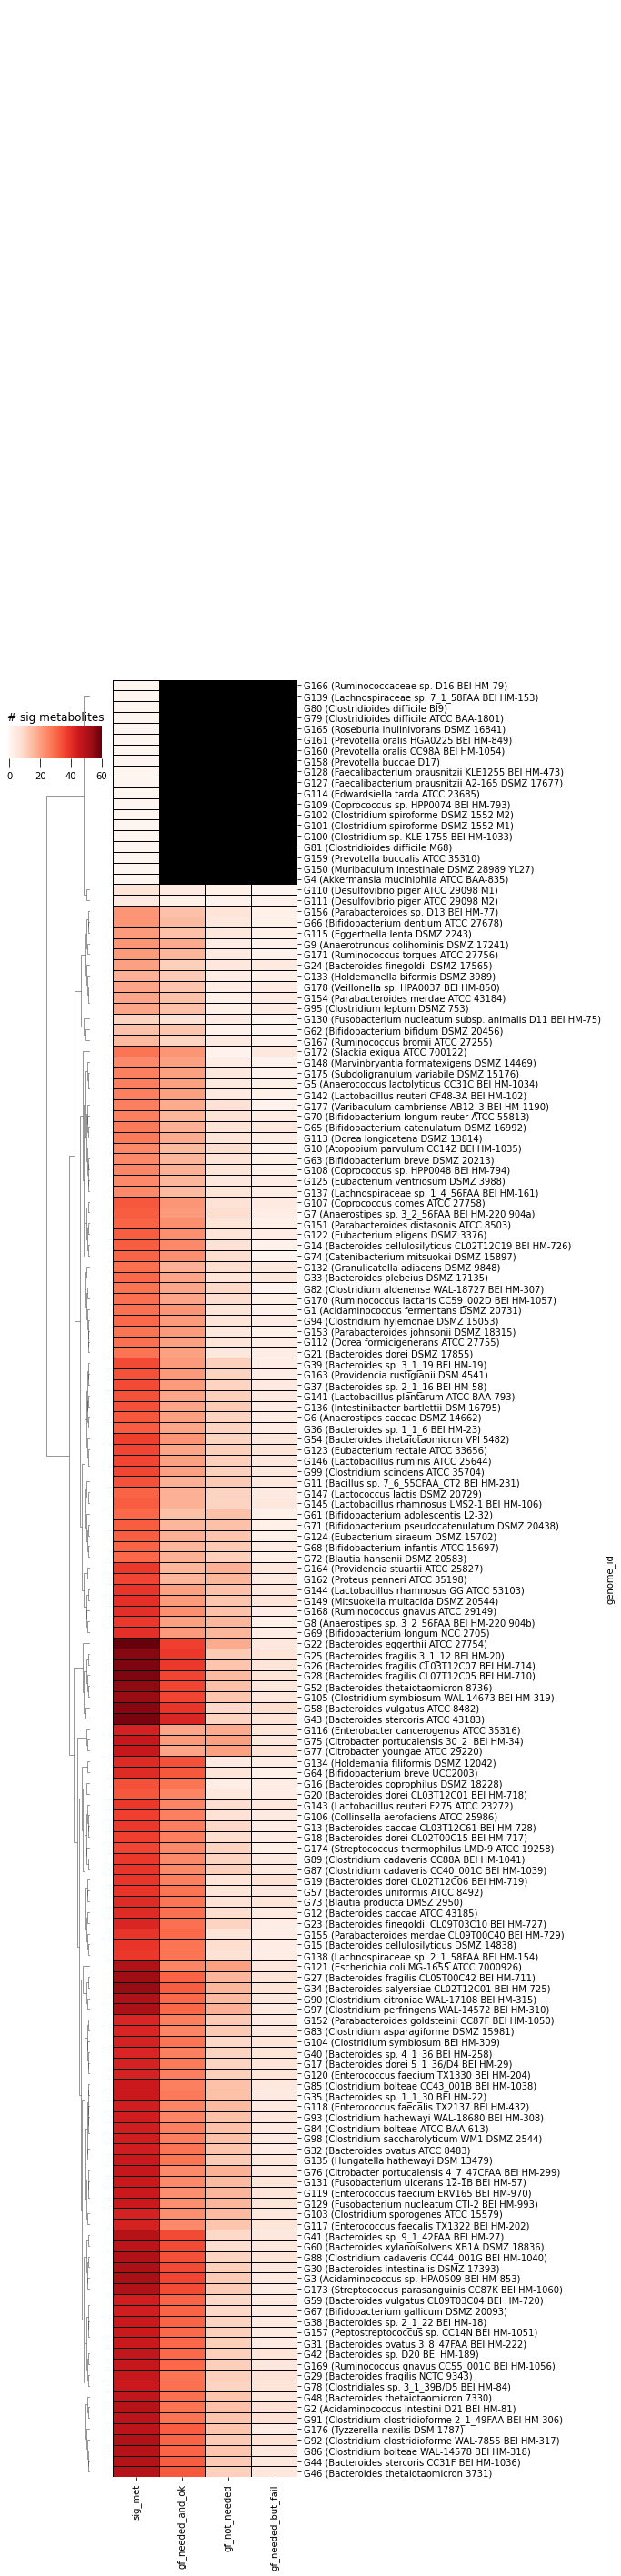

In [83]:
kws = dict(cbar_kws=dict(ticks=[0, 20, 40, 60], orientation='horizontal'))
df_stats_to_plot = df_stats.rename({x:'%s (%s)'%(x,y) for x,y in zip(df_strain_meta.genome_id, df_strain_meta.taxonomy)})
g = sns.clustermap(
    data = df_stats_to_plot.fillna(0),
    figsize=(5,50),
    col_cluster=False,
    row_cluster=True,
    mask=df_stats_to_plot.isnull(),
    vmin=0,
    vmax=60,
    cmap='Reds',
    linewidth=1,
    linecolor='k',
    **kws
)
x0, _y0, _w, _h = g.cbar_pos
g.ax_cbar.set_position([x0, 0.65, g.ax_row_dendrogram.get_position().width*2, 0.01])
g.ax_cbar.set_title('# sig metabolites')
g.ax_cbar.tick_params(axis='x', length=10)
g.ax_heatmap.xaxis.set_label_position('top')
g.ax_heatmap.set_facecolor('k')

plt.savefig('Figures/gapfilling_stats.png', dpi=300, bbox_inches = "tight")

# Optimize flux to achieve best correlation with measured fold change

In [335]:
G25_gf = joblib.load("gapfilled_G25.cobra.model")
G25_opt, G25_sol = optimize_flux(G25_gf, "G25", medium='mm', max_flux=1000.0, min_flux=0.01)

Bacteroides fragilis 3_1_12 BEI HM-20
EX_dad_5_e
EX_g3pc_e
EX_1acpc_e
EX_athr__L_e
EX_6dg_e
EX_Glc_aD_e
EX_creat_e
EX_gbbtn_e
Constrain reactions with significant fold changes finished. Obj = 8.00.
Constrain reactions without significant fold changes finished. Obj = 18.00.
Find pFBA solution finished. Obj = 26.57.


In [336]:
df2_fc = df_fc[(df_fc.log2fc_Padj<0.05) & (df_fc.genome_id=="G25") & (df_fc.media=="mm")]
df2_fc = df2_fc[['universal_bigg_id','log2fc_mean','log2fc_Padj']].sort_values('log2fc_mean').set_index('universal_bigg_id')
df_G25_sol = G25_sol.to_frame()
df_G25_sol = df_G25_sol.loc[[ex for ex in df_G25_sol.index if ex.startswith('EX_')], 'fluxes'].to_frame()
df_G25_sol = df_G25_sol.rename({ex:ex.split('EX_')[1].split('_e')[0] for ex in df_G25_sol.index})
df2_fc = pd.merge(df2_fc, df_G25_sol, left_index=True, right_index=True, how='left')
df2_fc['consistency'] = [np.sign(x)==np.sign(y) for x,y in zip(df2_fc.log2fc_mean, df2_fc.fluxes)]
df2_fc

log2fc_mean  log2fc_Padj    fluxes  consistency
universal_bigg_id                                                 
adn                  -5.628856     0.000887 -0.028983         True
asn__L               -4.677165     0.000008 -0.089984         True
uri                  -3.915440     0.003998 -0.010000         True
gln__L               -3.841652     0.000881 -0.010000         True
cytd                 -3.628611     0.002391 -0.036576         True
glygly               -3.063313     0.014162 -0.089378         True
4hbald               -2.341373     0.006788 -0.010000         True
gsn                  -2.174400     0.006001 -0.010000         True
all__D               -2.157159     0.003844 -0.010000         True
Glc_aD               -2.157159     0.003844 -0.000000        False
glc__aD              -2.157159     0.003844 -0.010000         True
man                  -2.157159     0.003844 -0.010000         True
glc__D               -2.157159     0.003844 -0.010000         True
srb__L               -2.157159     0.003844 -0.010000         True
ins                  -1.839831     0.011413 -0.010000         True
4abut                -1.495195     0.009815 -0.176969         True
mnl                  -1.267495     0.026338 -0.010000         True
galt                 -1.267495     0.026338 -0.010000         True
acrn                 -1.175288     0.002206 -0.010000         True
malt                 -1.021303     0.005139 -0.010000         True
pala                 -1.021303     0.005139 -0.010000         True
cellb                -1.021303     0.005139 -0.010000         True
6dg                  -1.021303     0.005139 -0.000000        False
sucr                 -1.021303     0.005139 -0.010000         True
ala_B                -0.920540     0.006306 -0.010000         True
hxan                 -0.904684     0.001041 -0.010000         True
athr__L              -0.871847     0.003941  0.000000        False
hom__L               -0.871847     0.003941 -0.087271         True
taur                 -0.838923     0.002068 -0.010000         True
ala__D               -0.639749     0.012699 -0.017448         True
sarcs                -0.639749     0.012699 -0.010000         True
gbbtn                -0.413071     0.003024  0.000000        False
4tmeabutn            -0.413071     0.003024 -0.010000         True
1acpc                -0.394375     0.004363 -0.000000        False
creat                -0.378668     0.030109  0.010000        False
acser                -0.237831     0.045086 -0.010000         True
leu__L               -0.153041     0.022300 -0.039304         True
phe__L                0.108177     0.011364  0.010000         True
g3pc                  0.147170     0.036828 -0.085875        False
chol                  0.405981     0.009620  0.075875         True
cyst__L               0.472969     0.022385  0.010000         True
his__L                0.473119     0.021765  0.010000         True
tyr__L                0.508474     0.011661  0.010000         True
met__L                0.738368     0.005775  0.010000         True
citr__L               0.794934     0.009409  0.010000         True
pro__L                1.519005     0.002632  0.010000         True
ach                   1.527152     0.035280  0.010000         True
gly                   1.592999     0.000778  0.010000         True
5aop                  1.715129     0.012196  0.010000         True
4hpro_LT              1.715129     0.012196  0.010000         True
thym                  1.769317     0.001053  0.010000         True
ahcys                 1.977269     0.000952  0.010000         True
ade                   2.101789     0.002119  0.010000         True
ind3eth               2.354416     0.002493  0.010000         True
ura                   2.946241     0.000196  0.010000         True
dad_5                 5.216584     0.011275 -0.000000        False